In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/home/ubuntu/crypto_prediction/git/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator

warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()

In [2]:
def create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
):
    """Load data form Hive mart table

        Args:
            target_schema: hive schema name
            target_table: hive table name
            target_columns: column name list to load
            target_symbol: symbol name (e.g., BTC_USDT)
            column_prefix: prefix name for each column

        Returns:
            data frame
    """
    query = f"""
    select
        {target_columns}
    from 
        hive.{target_schema}.{target_table}
    where
        id = '{target_symbol}'
    order by dt
    """

    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        # indicators_query_result[int(idx)] = row_data # use row number as index
        indicators_query_result[str(row_data[0])] = row_data # use date as index

    target_columns_list = [
        column_prefix + column.strip() for column in target_columns.strip().split(",")
    ]

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=target_columns_list
    )

    return indicators_raw_df


In [3]:
########################
# Load BTC_USDT OHLC and indicators
########################
target_schema = "crypto_mart"
target_table = "crypto_indicator_day"
target_symbol = "BTC_USDT"
column_prefix = "btc_"
target_columns = """
    dt,
    low,
    high,
    open,
    close,
    volume
    """

btc_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)

btc_raw_df.tail()

,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume
2023-10-10,2023-10-10,27300.01,27725.80,27590.00,27391.12,28203902.00
2023-10-11,2023-10-11,26547.40,27473.75,27394.06,26881.59,23001124.00
2023-10-12,2023-10-12,26563.15,26935.01,26878.10,26759.45,19693696.00
2023-10-13,2023-10-13,26685.48,27189.49,26753.69,26862.98,17459042.00
2023-10-14,2023-10-14,26853.74,26890.70,26862.78,26889.28,604814.94


In [4]:
####################################
# Create Dataset with target value
####################################

# Check if all "date" exist in the dataframe.
first_dt = str(btc_raw_df.iloc[0]['btc_dt'])
last_dt = str(btc_raw_df.iloc[-1]['btc_dt'])
desired_date_range = pd.date_range(start=first_dt, end=last_dt, freq='D')
all_dates_exist = all(str(date)[:11].strip() == str(btc_raw_df.iloc[i]['btc_dt']).strip() for i,date in enumerate(desired_date_range))
if all_dates_exist:
    print("All dates exist in the DataFrame's index.")
else:
    print("Not all dates exist in the DataFrame's index.")

btc_df_with_target = btc_raw_df

# Create target value to predict
# Predict the "close" value after N days.
predicting_days = 1
target = btc_raw_df['btc_close'].shift(-predicting_days) # shift data from df[N+1] to df[N]
btc_df_with_target['target'] = target

btc_df_with_target.tail()

All dates exist in the DataFrame's index.


,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume,target
2023-10-10,2023-10-10,27300.01,27725.80,27590.00,27391.12,28203902.00,26881.59
2023-10-11,2023-10-11,26547.40,27473.75,27394.06,26881.59,23001124.00,26759.45
2023-10-12,2023-10-12,26563.15,26935.01,26878.10,26759.45,19693696.00,26862.98
2023-10-13,2023-10-13,26685.48,27189.49,26753.69,26862.98,17459042.00,26889.28
2023-10-14,2023-10-14,26853.74,26890.70,26862.78,26889.28,604814.94,NaN


In [5]:
btc_df_with_target.describe()

,btc_low,btc_high,btc_open,btc_close,btc_volume,target
count,1078.000000,1078.000000,1078.000000,1078.000000,1.078000e+03,1077.000000
mean,32762.245909,34549.964592,33702.887365,33715.711633,2.798141e+07,33734.252451
std,12601.735209,13462.160696,13079.803129,13067.456834,3.603530e+07,13059.334047
min,13207.510000,13825.000000,13556.050000,13558.840000,1.945060e+03,13558.840000
25%,22444.410000,23344.697500,22939.605000,22940.520000,4.775556e+06,22947.600000
50%,29353.925000,30467.720000,29912.810000,29912.300000,1.519053e+07,29912.500000
75%,42121.097500,44175.725000,43085.290000,43103.600000,3.653574e+07,43111.860000
max,66264.540000,69000.000000,67480.450000,67523.940000,2.573676e+08,67523.940000


In [6]:
# Drop date column
btc_dt = btc_df_with_target['btc_dt']
dataset_raw_df = btc_df_with_target.drop(['btc_dt'], axis=1)
dataset_raw_df.tail()

,btc_low,btc_high,btc_open,btc_close,btc_volume,target
2023-10-10,27300.01,27725.80,27590.00,27391.12,28203902.00,26881.59
2023-10-11,26547.40,27473.75,27394.06,26881.59,23001124.00,26759.45
2023-10-12,26563.15,26935.01,26878.10,26759.45,19693696.00,26862.98
2023-10-13,26685.48,27189.49,26753.69,26862.98,17459042.00,26889.28
2023-10-14,26853.74,26890.70,26862.78,26889.28,604814.94,NaN


In [12]:
from sklearn import metrics
from xgboost import XGBRegressor


# create Train & Test data
train_window_list = [
    ["2021-01-01", "2022-12-31"],
    ["2021-02-01", "2023-01-31"],
    ["2021-03-01", "2023-02-28"],
    ["2021-04-01", "2023-03-31"],
    ["2021-05-01", "2023-04-30"],
    ["2021-06-01", "2023-05-31"],
    ["2021-07-01", "2023-06-30"],
    ["2021-08-01", "2023-07-31"],
    ["2021-09-01", "2023-08-31"],
]
test_window_list = [
    ["2023-01-01", "2023-01-31"],
    ["2023-02-01", "2023-02-31"],
    ["2023-03-01", "2023-03-31"],
    ["2023-04-01", "2023-04-30"],
    ["2023-05-01", "2023-05-31"],
    ["2023-06-01", "2023-06-30"],
    ["2023-07-01", "2023-07-31"],
    ["2023-08-01", "2023-08-31"],
    ["2023-09-01", "2023-09-30"],
]

models = {
    "XGBRegressor": XGBRegressor(learning_rate = 0.01,
                           n_estimators  = 1000,
                           max_depth     = 5,
                           early_stopping_rounds=10,
                           eval_metric='rmsle',
                           verbosity=0),
}


def train_model(model):
    fold_count = 0
    test_period = 0
    avg_model_result = {}
    
    for train_window, test_window in zip(train_window_list, test_window_list):
        # Prepare train data
        X_train = dataset_raw_df.drop(["target"], axis=1)
        X_train = X_train.loc[train_window[0] : train_window[1]].to_numpy()
        y_train = (
            dataset_raw_df["target"].loc[train_window[0] : train_window[1]].to_numpy()
        )
    
        # Prepare test data
        X_test = dataset_raw_df.drop(["target"], axis=1)
        X_test_today_close = (
            X_test["btc_close"].loc[test_window[0] : test_window[1]].to_numpy()
        )
        X_test = X_test.loc[test_window[0] : test_window[1]].to_numpy()
        y_test = (
            dataset_raw_df["target"].loc[test_window[0] : test_window[1]].fillna(0).to_numpy()
        )
        
        test_dt_array = np.array(dataset_raw_df.loc[test_window[0] : test_window[1]].index.tolist())
            
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
        )
        
        y_pred = model.predict(X_test)
    
        if fold_count == 0:
            all_dt = test_dt_array
            all_real = y_test
            all_pred = y_pred
            all_X_test_today_close = X_test_today_close
        else:
            all_dt = np.append(all_dt, test_dt_array)
            all_real = np.append(all_real, y_test)
            all_pred = np.append(all_pred, y_pred)
            all_X_test_today_close = np.append(all_X_test_today_close, X_test_today_close)
        fold_count += 1
    
        avg_model_result[tuple(test_window)] = {
            "pred_close_value": y_pred,
            "mae": metrics.mean_absolute_error(y_test, y_pred),
            "mse": metrics.mean_squared_error(y_test, y_pred),
            "rmse": np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        }
    
    
    total_mae = 0.0
    total_mse = 0.0
    total_rmse = 0.0
    
    for _, res in avg_model_result.items():
        total_mae += res["mae"]
        total_mse += res["mse"]
        total_rmse += res["rmse"]
    avg_mae = total_mae / len(avg_model_result)
    avg_mse = total_mse / len(avg_model_result)
    avg_rmse = total_rmse / len(avg_model_result)
    
    model_results = {
        "dt_today": all_dt,
        "actual_nextday_close_value": all_real,
        "predicted_nextday_close_value": all_pred,
        "actual_today_close_value": all_X_test_today_close,
        "avg_mae": avg_mae,
        "avg_mse": avg_mse,
        "avg_rmse": avg_rmse,
    }

    return model_results

all_model_results = {}
for model_name, model in models.items():
    all_model_results[model_name] = train_model(model)

[0]	validation_0-rmsle:0.63011
[1]	validation_0-rmsle:0.62564
[2]	validation_0-rmsle:0.62120
[3]	validation_0-rmsle:0.61679
[4]	validation_0-rmsle:0.61241
[5]	validation_0-rmsle:0.60804
[6]	validation_0-rmsle:0.60366
[7]	validation_0-rmsle:0.59934
[8]	validation_0-rmsle:0.59492
[9]	validation_0-rmsle:0.59061
[10]	validation_0-rmsle:0.58623
[11]	validation_0-rmsle:0.58201
[12]	validation_0-rmsle:0.57759
[13]	validation_0-rmsle:0.57329
[14]	validation_0-rmsle:0.56901
[15]	validation_0-rmsle:0.56466
[16]	validation_0-rmsle:0.56044
[17]	validation_0-rmsle:0.55623
[18]	validation_0-rmsle:0.55204
[19]	validation_0-rmsle:0.54779
[20]	validation_0-rmsle:0.54359
[21]	validation_0-rmsle:0.53938
[22]	validation_0-rmsle:0.53541
[23]	validation_0-rmsle:0.53134
[24]	validation_0-rmsle:0.52721
[25]	validation_0-rmsle:0.52318
[26]	validation_0-rmsle:0.51918
[27]	validation_0-rmsle:0.51520
[28]	validation_0-rmsle:0.51108
[29]	validation_0-rmsle:0.50725
[30]	validation_0-rmsle:0.50325
[31]	validation_0-

accuracy: 0.5128
recall: 0.5191
precision: 0.4928
f1: 0.5056
avg_mae: 589.1498398150815
avg_mse: 732772.2707876223
avg_rmse: 772.2493765689355


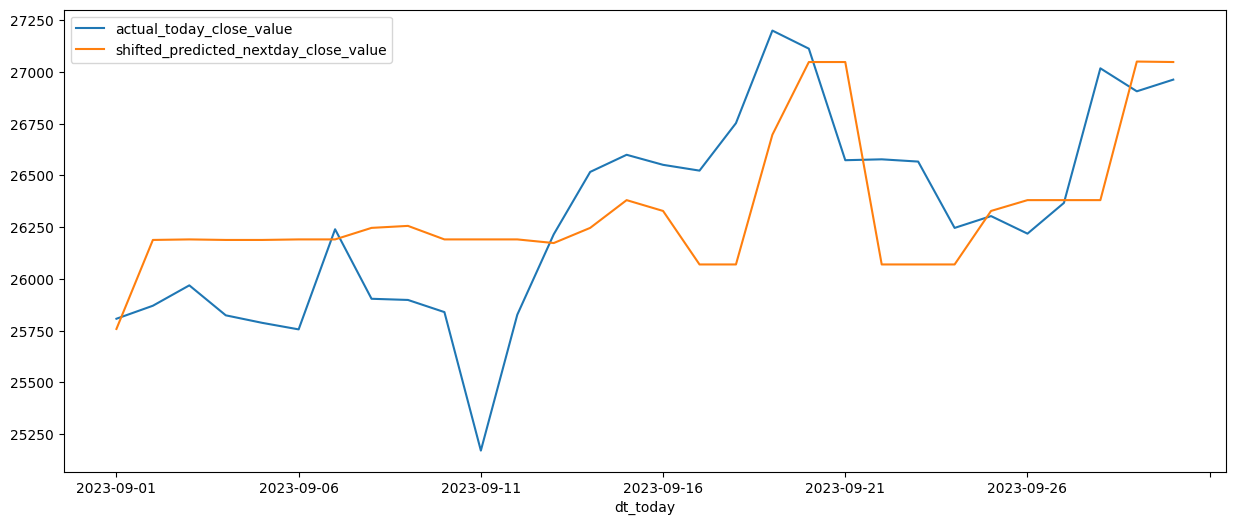

In [11]:
def show_model_result(model_results):
    # Creating the Numpy array
    array = np.array([
        model_results["dt_today"], 
        model_results["actual_today_close_value"], 
        model_results["actual_nextday_close_value"], 
        model_results["predicted_nextday_close_value"]
    ]).transpose()
    
    # Creating a list of column names
    column_values = ["dt_today", 
                     "actual_today_close_value", 
                     "actual_nextday_close_value", 
                     "predicted_nextday_close_value"]
    
    # creating the dataframe
    df = pd.DataFrame(data=array, columns=column_values)
    
    shifted_pred = df["predicted_nextday_close_value"].shift(predicting_days)
    df["shifted_predicted_nextday_close_value"] = shifted_pred
    
    df = df.set_index("dt_today")
    
    df = df.where(pd.notna(df), np.nan).fillna(0.0)
    
    convert_dict = {'actual_today_close_value': float,
                    'actual_nextday_close_value': float,
                    'predicted_nextday_close_value': float,
                    'shifted_predicted_nextday_close_value': float}
    df = df.astype(convert_dict)
    
    
    df[["actual_today_close_value", "shifted_predicted_nextday_close_value"]].iloc[-30:].plot(figsize=(15, 6))
    
    
    df["actual_today_close_value"] = model_results["actual_today_close_value"]
    df = df.drop(["predicted_nextday_close_value"], axis=1)
    df["real_up"] = np.where(df["actual_today_close_value"] < df["actual_nextday_close_value"], 1, 0)
    df["pred_up"] = np.where(df["actual_today_close_value"] < df["shifted_predicted_nextday_close_value"], 1, 0)
    
    tp = tn = fp = fn = 0
    for dt_ in model_results["dt_today"]:
        # 1: up, 0: down
        if df.loc[dt_, "real_up"] == 1 and df.loc[dt_, "pred_up"] == 1:
            tp += 1
        elif df.loc[dt_, "real_up"] == 0 and df.loc[dt_, "pred_up"] == 0:
            tn += 1
        elif df.loc[dt_, "real_up"] == 1 and df.loc[dt_, "pred_up"] == 0:
            fn += 1
        elif df.loc[dt_, "real_up"] == 0 and df.loc[dt_, "pred_up"] == 1:
            fp += 1
    
    acc = round(((tp + tn) / (tp + tn + fn + fp)), 4)
    recall = round(((tp) / (tp + fn)), 4)
    precision = round(((tp) / (tp + fp)), 4)
    f1 = round((2 * recall * precision) / (recall + precision), 4)
    
    print("accuracy:", acc)
    print("recall:", recall)
    print("precision:", precision)
    print("f1:", f1)
    
    print("avg_mae:", model_results["avg_mae"])
    print("avg_mse:", model_results["avg_mse"])
    print("avg_rmse:", model_results["avg_rmse"])

# show result for LinearRegression
show_model_result(all_model_results['XGBRegressor'])